# Rozdział 6 - Drzewa decyzyjne

## 1. Uczenie i wizualizowanie drzewa decyzyjnego

In [68]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, 2:] # Długość, szerokość płatka
y = iris.target

In [69]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

In [70]:
from sklearn.tree import export_graphviz
from graphviz import Source

export_graphviz(
    tree_clf,
    out_file="iris_drzewo.dot",
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

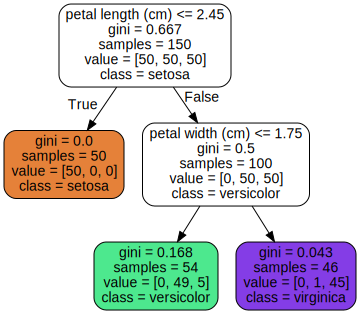

In [71]:
Source.from_file("iris_drzewo.dot")

## 2. Szacowanie prawdopodobieństwa przynależności do klas

In [72]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [73]:
tree_clf.predict([[5, 1.5]])

array([1])

## 3. Regresja

In [75]:
import numpy as np

np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [76]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

## Ćwiczenia

#### 7.

In [90]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4)

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [94]:
from sklearn.model_selection import GridSearchCV

param_grid_tree_clf = [
    {"max_leaf_nodes": [8, 9, 10, 11, 12, 15, 18, 19, 20, 21, 22, 23, 24, 25]}
]

tree_clf = DecisionTreeClassifier(random_state=69)
tree_clf_grid = GridSearchCV(tree_clf, param_grid_tree_clf, cv=5, scoring='accuracy')
tree_clf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=69),
             param_grid=[{'max_leaf_nodes': [8, 9, 10, 11, 12, 15, 18, 19, 20,
                                             21, 22, 23, 24, 25]}],
             scoring='accuracy')

In [95]:
tree_clf_grid.best_params_

{'max_leaf_nodes': 22}

In [96]:
tree_clf_grid.best_score_

0.8592500000000001

In [97]:
tree_clf_mod = DecisionTreeClassifier(max_leaf_nodes=22, random_state=69)
tree_clf_mod.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=22, random_state=69)

In [98]:
y_pred = tree_clf_mod.predict(X_test)

In [99]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.8675

#### 8.

In [100]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=69)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

In [106]:
len(mini_sets)

1000

In [108]:
len(X_train) - n_instances

7900

In [110]:
from sklearn.base import clone

forest = [clone(tree_clf_grid.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)

    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.801098

In [112]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [113]:
Y_pred

array([[1, 1, 0, ..., 1, 0, 1],
       [1, 1, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 0, 1],
       ...,
       [1, 1, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       [1, 1, 0, ..., 0, 1, 0]], dtype=uint8)

In [114]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

In [115]:
y_pred_majority_votes

array([[1, 1, 0, ..., 1, 1, 1]], dtype=uint8)

In [116]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.873